#data discription

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

rating = pd.read_csv('/content/drive/MyDrive/데이터마이닝 과제/temp_dataset/temp_dataset/temp_ratings.csv')
movies = pd.read_csv('/content/drive/MyDrive/데이터마이닝 과제/temp_dataset/temp_dataset/temp_movies.csv')

In [ ]:
rating.head()

,userId,movieId,rating,timestamp
0,37438,1020,3.0,1047069348
1,113448,32,4.0,1271679905
2,52106,377,4.0,995749037
3,159710,10,3.0,856352560
4,45095,296,5.0,834960212


In [ ]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     10000 non-null  int64  
 1   movieId    10000 non-null  int64  
 2   rating     10000 non-null  float64
 3   timestamp  10000 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 312.6 KB


In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  1000 non-null   int64 
 1   title    1000 non-null   object
 2   genres   1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


##Word Cloud - title

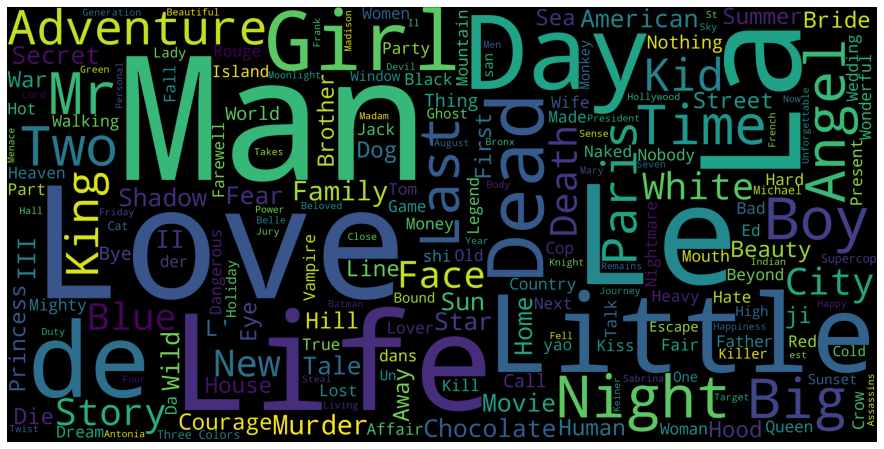

In [ ]:
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS

#title cloud
movies['title'] = movies['title'].fillna("").astype('str')
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, height=2000, width=4000).generate(title_corpus)

plt.figure(figsize=(16, 8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

In [ ]:
rating['rating'].describe()

count    10000.000000
mean         3.555500
std          1.063688
min          0.500000
25%          3.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: rating, dtype: float64

##rating count

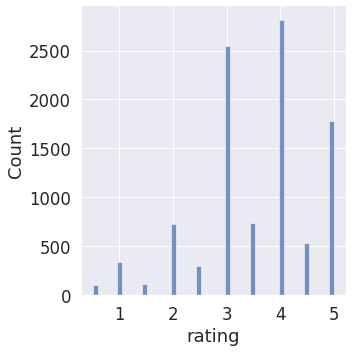

In [ ]:
import seaborn as sns
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline

sns.displot(rating['rating'].fillna(rating['rating'].median()))

##데이터셋 merge 후 rating이 높은 순대로 정렬

In [ ]:
dataset = pd.merge(movies, rating)
dataset[['title', 'genres', 'rating']].sort_values('rating', ascending=False).head(20)

,title,genres,rating
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0
8222,Twister (1996),Action|Adventure|Romance|Thriller,5.0
2855,Ed Wood (1994),Comedy|Drama,5.0
2862,French Kiss (1995),Action|Comedy|Romance,5.0
8196,"Rock, The (1996)",Action|Adventure|Thriller,5.0
8197,Cemetery Man (Dellamorte Dellamore) (1994),Horror,5.0
5700,"Fugitive, The (1993)",Thriller,5.0
8200,Twister (1996),Action|Adventure|Romance|Thriller,5.0
2864,French Kiss (1995),Action|Comedy|Romance,5.0
5699,"Fugitive, The (1993)",Thriller,5.0


##genre

In [ ]:
genre_labels = set()

for s in movies['genres'].str.split('|').values:
  genre_labels = genre_labels.union(set(s))


def count_word(dataset, ref_col, census):
  keyword_cnt = dict()
  for s in census:
    keyword_cnt[s] = 0
  for census_keywords in dataset[ref_col].str.split('|'):
    if type(census_keywords) == float and pd.isnull(census_keywords):
      continue
    for s in [s for s in census_keywords if s in census]:
      if pd.notnull(s):
        keyword_cnt[s] += 1
  
  keyword_occ = []
  for k, v in keyword_cnt.items():
    keyword_occ.append([k, v])
  keyword_occ.sort(key=lambda x:x[1], reverse=True)

  return keyword_occ, keyword_cnt

keyword_occ, dum = count_word(movies, 'genres', genre_labels)
keyword_occ[:5]

[['Drama', 522],
 ['Comedy', 355],
 ['Romance', 199],
 ['Thriller', 173],
 ['Action', 136]]

##genre wordcloud

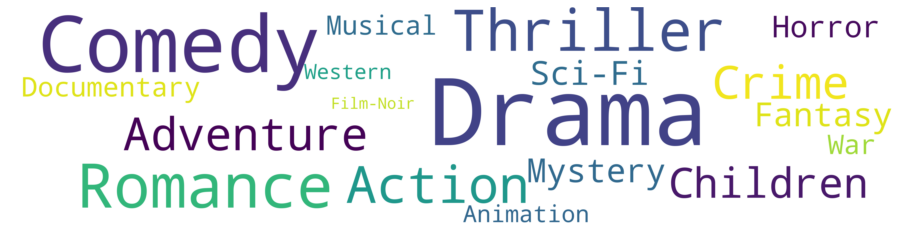

In [ ]:
genres = dict()
trunc_occurences = keyword_occ[0:18]
for s in trunc_occurences:
  genres[s[0]] = s[1]

genre_wordcloud = WordCloud(width=4000, height=1000, background_color='white')
genre_wordcloud.generate_from_frequencies(genres)

f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# recommend system

In [ ]:
! pip install surprise

     |████████████████████████████████| 11.8MB 5.9MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617644 sha256=fab123c9a399aacb604fcb4d17e390680e5c3e7c4ba1168571ff644be7c4f19f
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
from surprise import SVD, accuracy
from surprise.model_selection import train_test_split
import pandas as pd
from surprise import Reader, Dataset

## 데이터 불러오기

In [ ]:
#data = Dataset.load_builtin('ml-100k')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/데이터마이닝 과제/temp_dataset/temp_dataset/temp_ratings.csv'
ratings = pd.read_csv(file_path) 

reader = Reader(rating_scale=(0.5, 5.0)) # (min, max)

# ratings DataFrame 에서 컬럼은 사용자 아이디, 아이템 아이디, 평점 순서를 지켜야 함. 
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,37438,1020,3.0,1047069348
1,113448,32,4.0,1271679905
2,52106,377,4.0,995749037
3,159710,10,3.0,856352560
4,45095,296,5.0,834960212


In [ ]:
data

## SVD 추천 알고리즘 구현
- **parameters**
    - n_factors: 잠재요인의 개수, 커질 수록 정확도가 높아질 수 있으나 과적합 문제가 발생할 수 있음.
    - n_epochs: SGD 수행 시 반복 횟수.
    - biased(bool): 베이스라인 사용자 편향 적용 여부



- 베이스라인 평점
    - 개인이 아이템에 평가를 후하게 주는지? 박하게 주는지? 개인의 별점 성향을 반영
    - 보통은 `전체 평균 평점 + 사용자 편향 점수 + 아이템 편향 점수`로 계산 됨
        - 사용자 편향 점수 = 사용자별 아이템 평점 평균 값 - 전체 평균 평점
        - 아이템 편향 점수 = 아이템별 평점 평균 값 - 전체 평균 평점

In [ ]:
trainset, testset = train_test_split(data, test_size=.25, random_state=1234)

In [ ]:
algo = SVD(n_factors=50, biased=True, random_state=0)
algo.fit(trainset)

In [ ]:
predictions = algo.test(testset)

In [ ]:
predictions[:5]

[Prediction(uid=139585, iid=338, r_ui=2.5, est=3.5363564467006383, details={'was_impossible': False}),
 Prediction(uid=81181, iid=48, r_ui=2.0, est=3.4480080097660255, details={'was_impossible': False}),
 Prediction(uid=112175, iid=261, r_ui=4.0, est=3.807584698535285, details={'was_impossible': False}),
 Prediction(uid=38584, iid=480, r_ui=3.0, est=3.634299601094103, details={'was_impossible': False}),
 Prediction(uid=108414, iid=260, r_ui=4.5, est=4.053956499933353, details={'was_impossible': False})]

In [ ]:
# RMSE (Root Mean Square Error)
# MAE (Mean Absolute Error)
accuracy.rmse(predictions)
accuracy.mse(predictions)

RMSE: 0.9773
MSE: 0.9552


0.9551508952190411

## 교차 검증(Cross Validation)

In [ ]:
from surprise.model_selection import cross_validate 
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9742  0.9924  0.9697  0.9717  0.9937  0.9804  0.0104  
MAE (testset)     0.7653  0.7845  0.7673  0.7525  0.7681  0.7675  0.0102  
Fit time          0.33    0.31    0.32    0.32    0.33    0.32    0.01    
Test time         0.01    0.02    0.01    0.01    0.01    0.01    0.00    


{'fit_time': (0.3304152488708496,
  0.30994343757629395,
  0.3198978900909424,
  0.3185608386993408,
  0.33231186866760254),
 'test_mae': array([0.76526448, 0.78449358, 0.76734641, 0.7524767 , 0.76807979]),
 'test_rmse': array([0.97423873, 0.9923587 , 0.96974407, 0.97174607, 0.99368145]),
 'test_time': (0.012844324111938477,
  0.019207000732421875,
  0.013327836990356445,
  0.012675046920776367,
  0.012657642364501953)}

## 하이퍼 파라미터 튜닝

In [ ]:
from surprise.model_selection import GridSearchCV
# 테스트할 파라미터들을 딕셔너리 형태로 지정. 
param_grid = {'n_epochs': [20, 40, 60], 'n_factors': [50, 100, 200]}

# CV를 3개 폴드 세트로 지정, 성능 평가는 rmse, mse 로 수행 하도록 GridSearchCV 구성
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

In [ ]:
#  RMSE Evaluation 점수와 그때의 하이퍼 파라미터
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.9803766163836182
{'n_epochs': 60, 'n_factors': 50}
